# Introduction

Hierarchical or multilevel model is suitable when you want to model a problem that has some structure. For example, given you want to study the survival probability, $\theta_j$, of patients in a number of hostipitals. It is reasonable to assume that these probobabilities are related to each other, i.e., sampled from a common distributions. 

Hierarchical models have several advantages:

1. It prevent overfitting data in the sense that it has better prediction over future data.
2. It is often sensisble to user more parameters than data points in a hierarchical model.

In this notebook, we will illustrate conjugate hierarchical models which enables easy sampling for posterior inference. Complicated non-conjugate models can be dealt with using advanced sampling techniques such as MCMC. Please see the MCMC notebook for details..

### General Inference Steps
In general we have hyperparameters $\phi$ and parameters $\theta$. The general full Bayesian analysis of this  hierarchical is as follows:

1. Derive the joint posterior probability of all parameters of the model, i.e., $(\theta, \phi)$: $p(\theta, \phi |y) \propto p(\theta|\phi)p(y|\theta)$
2. Derive the conditional posterior density of $\theta$, (parameters of interest): $p(\theta | \phi, y)$
3. Estimate $\phi$ using the Bayesian paradignm:  $p(\phi \mid y) = \frac{p(\theta, \phi \mid y)}{p(\theta \mid \phi, y)}$ or $p(\theta |y) = \int p(\theta, \phi |y)d\theta$

Note that in step 3, the first formula for computing posterior distribution of hyperparameters $\phi$ is mostly applicable in conjugate hierarhical model since the denominator is an integral that is hard to evaluate in case of nonconjugacy.


### General Sampling Procedure for Inference in Hierarchical Model

The following steps are for generating draws from the joint posterior distribution $p(\theta, \phi|y)$:

1. Draw the vector of hyperparameters, $\phi$, from its marginal posterior distribution $p(\phi |y)$ using any sampling techniques: grid, MCMC, importance sampling.
2. Draw the parameter vector $\theta$ from its conditional posterior distribution $p(\theta | \phi,  y)$.
3. If desired, draw predictive values $\widetilde{y}$ from posterior predictive distribution given the drawn $\theta$: $p(\widetilde{y}|n, \theta)$

Let's see how this applies to a case study.

# Rat tumor case study
Given data about 71 experiments: $\{(y_j, n_j)\}$, $j = 1 \dots 71$. $y_j$ is the number of female rats that develop tumor out of $n_j$ of them. Our job is to estimate the probability of developing tumor in all 71 experiments. It is natural to model the number of rats that have tumors in each experiment using Binomial distribution and using $Beta(\alpha, \beta)$ as a prior distribution for all probability of developing tumor $\theta_j$. We assume that each $\theta_i$ are drawn from a population distribution given by a conjugate Beta prior $Beta(\alpha, \beta)$ with parameters $\alpha$ and $\beta$ to describe this data.

$$\begin{align}\theta_j &\sim Beta(\alpha, \beta)\\
p(\Theta| \alpha, \beta) &= \prod_{j=1}^{70}Beta(\theta_i, \alpha, \beta)
\end{align}$$

The schematic view of this model is:
The structure of this model is shown as follows: ![](./gfx/rat_model.png)

Models such as the one above are called **hierarchical model**, with observable outcomes ($y_j$) modeled conditionally on certain parameters ($\theta_i)$, which themselves are given a probabilistic specification in terms of hyperparameters. Modeling in this way has two advantages:

1. It helps us develop a computational strategy to solve the problem

2. It allows estimates of the probabilities of any one of the units (here, one of the experiments) to borrow strength from all the data as a whole through the estimation of the hyperparameters. In other words, if some of the experiments had lower sample sizes or other outlier like behavior, the procedure helps “regularize” this.

In [20]:
import numpy as np
from scipy.stats import beta
from scipy.special import gammaln

%matplotlib inline
import matplotlib.pyplot as plt

In [21]:
import os, sys
# add utilities directory to path
util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import plot_tools

In [22]:
# edit default plot settings
plt.rc('font', size=12)
# apply custom background plotting style
plt.style.use(plot_tools.custom_styles['gray_background'])

In [75]:
# rat data (BDA3, p. 102)
y = np.array([
     0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
     1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,  2,
     5,  3,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
    10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
    15,  9,  4
])
n = np.array([
    20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
    20, 19, 19, 18, 18, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19,
    46, 27, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
    48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
    47, 24, 14
])
M = len(y)

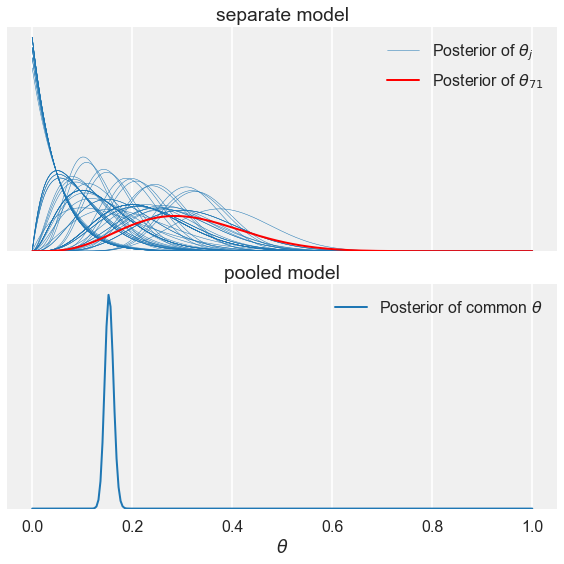

In [49]:
# plot the separate and pooled models
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
x = np.linspace(0, 1, 250)

# separate
ax = axes[0]
lines = ax.plot(
    x,
    beta.pdf(x[:,None], y + 1, n - y + 1),
    color='C0',
    linewidth=0.5
)
# highlight the last line
lines[-1].set_linewidth(2)
lines[-1].set_color('r')
ax.legend(
    (lines[0], lines[-1]),
    (r'Posterior of $\theta_j$',
     r'Posterior of $\theta_{71}$')
)
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero
ax.set_yticks(())
ax.set_title('separate model')

# pooled
ax = axes[1]
ax.plot(
    x,
    beta.pdf(x, y.sum() + 1, n.sum() - y.sum() + 1),
    linewidth=2,
    label=(r'Posterior of common $\theta$')
)
ax.legend()
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero
ax.set_yticks(())
ax.set_xlabel(r'$\theta$')
ax.set_title('pooled model')

fig.tight_layout()

Please see BDA p. 110 for the formula of posterior distribution $p(\alpha, \beta |y)$. Here we focus on constructing a noninformative hyperprior distribution $p(\alpha, \beta)$. Because we have no immediately availbable information about the distribution of tumor rates in population of rates, we want to have a diffuse hyperprior distribution for $\alpha, \beta$.

One need to be careful when constructing a prior distribution to make sure the posterior distribution is proper. In the case that we have relative large amount of data, it is possible to set up a diffuse prior that is dominated by the likelihood and yields a proper posterior distribution. In this case, we can have a uniform distribution on $(\frac{\alpha}{\alpha + \beta}, (\alpha + \beta)^{-1/2})$. Transform this back to the normal scale $(\alpha, \beta)$ we have $p(\alpha, \beta) \propto (\alpha + \beta)^{-5/2}$

In [76]:
# compute the marginal posterior of alpha and beta in the hierarchical model in a grid
A = np.linspace(0.5, 6, 100)
B = np.linspace(3, 33, 100)
# calculated in logarithms for numerical accuracy
lp = (
  - 5/2 * np.log(A + B[:,None])
  + np.sum(
        gammaln(A + B[:,None])
      - gammaln(A)
      - gammaln(B[:,None])
      + gammaln(A + y[:,None,None])
      + gammaln(B[:,None] + (n - y)[:,None,None])
      - gammaln(A + B[:,None] + n[:,None,None]),
        axis=0
    )
)
# subtract the maximum value to avoid over/underflow in exponentation
# note that this is similar to log-sum-exp trick.
lp -= lp.max()
p = np.exp(lp)

Vectorization operation in the above code seems to be complex at first sight but the the key idea is to be consistent with which axis is assigned to which variable. For example, in the above code, we have:

1. A is assigned to second axis (column): A
2. B is assigned to the first axis (row): B[:, None]
3. A + y[:, None, None], with this y is assigned the first axis, and A is the third (last axis). 
4. then when ``- gammaln(B[:,None]) + gammaln(A + y[:,None,None])`` is executed, y is the first axis, B is the second axis and A is the last axis. 
5. That's why we summ over the first axis meaning summing over y. This result in to a two dimensional matrix where B now is the first axis (row) 

In [79]:
a = np.array([1, 2])
b = np.array([1, 2])
y = np.array([3, 4])
tmp = a + y[:, None, None]
tmp

array([[[4, 5]],

       [[5, 6]]])

In [80]:
b[:, None] + tmp

array([[[5, 6],
        [6, 7]],

       [[6, 7],
        [7, 8]]])

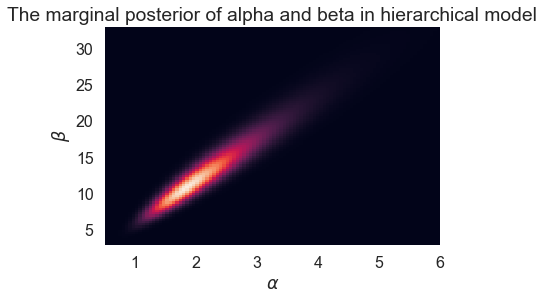

In [72]:
# # plot the marginal posterior
# plt.imshow(
#     p,
#     origin='lower',
#     aspect='auto',
#     extent=(A[0], A[-1], B[0], B[-1])
# )
# plt.xlabel(r'$\alpha$')
# plt.ylabel(r'$\beta$')
# plt.title('The marginal posterior of alpha and beta in hierarchical model')
# plt.grid('off')
# plot the marginal posterior
plt.imshow(
    p,
    origin='lower',
    aspect='auto',
    extent=(A[0], A[-1], B[0], B[-1])
)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.title('The marginal posterior of alpha and beta in hierarchical model')
plt.grid('off')

In [57]:
# sample from the posterior grid of alpha and beta
nsamp = 1000
samp_indices = np.unravel_index(
    np.random.choice(p.size, size=nsamp, p=p.ravel()/p.sum()),
    p.shape
)
samp_A = A[samp_indices[1]]
samp_B = B[samp_indices[0]]
# add random jitter, see BDA3 p. 76
samp_A += (np.random.rand(nsamp) - 0.5) * (A[1]-A[0])
samp_B += (np.random.rand(nsamp) - 0.5) * (B[1]-B[0])

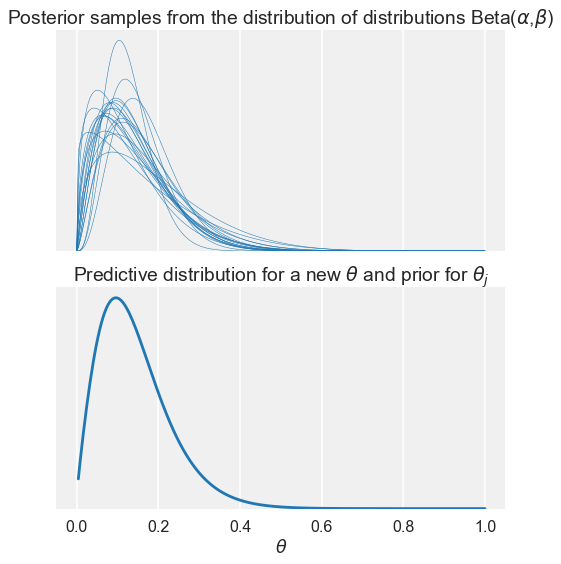

In [58]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 8))

# Plot samples from the distribution of distributions Beta(alpha,beta),
# that is, plot Beta(alpha,beta) using the posterior samples of alpha and beta
ax = axes[0]
ax.plot(
    x,
    beta.pdf(x[:,None], samp_A[:20], samp_B[:20]),
    linewidth=0.5,
    color='C0'
)
ax.set_yticks(())
ax.set_title(
    r'Posterior samples from the distribution of distributions '
    r'Beta($\alpha$,$\beta$)'
)
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero

# The average of above distributions, is the predictive distribution for a new
# theta, and also the prior distribution for theta_j.
# Plot this.
ax = axes[1]
plt.plot(x, np.mean(beta.pdf(x, samp_A[:,None], samp_B[:,None]), axis=0))
ax.set_yticks(())
ax.set_xlabel(r'$\theta$')
ax.set_title(
    r'Predictive distribution for a new $\theta$ '
    r'and prior for $\theta_j$'
)
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero

fig.tight_layout()


# Hierarchical Model (draft)

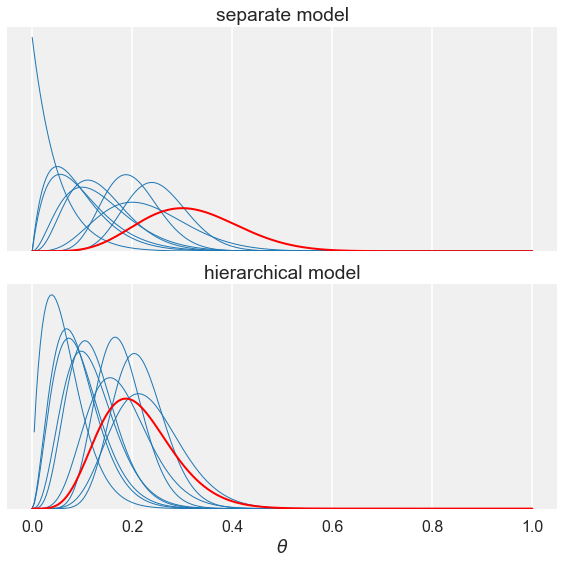

In [19]:
# And finally compare the separate model and the hierarchical model
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
x = np.linspace(0, 1, 250)

# first plot the separate model (same as above)
ax = axes[0]
# note that for clarity only every 7th distribution is plotted
lines = ax.plot(
    x,
    beta.pdf(x[:,None], y[7:-1:7] + 1, n[7:-1:7] - y[7:-1:7] + 1),
    color='C0',
    linewidth=1
)
# highlight the last line
lines[-1].set_linewidth(2)
lines[-1].set_color('r')
ax.set_yticks(())
ax.set_title('separate model')
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero

# And the hierarchical model. Note that these marginal posteriors for theta_j are
# more narrow than in the separate model case, due to the borrowed information from
# the other theta_j's.
ax = axes[1]
# note that for clarity only every 7th distribution is plotted
lines = ax.plot(
    x,
    np.mean(
        beta.pdf(
            x[:,None],
            y[7::7] + samp_A[:,None,None],
            n[7::7] - y[7::7] + samp_B[:,None,None]
        ),
        axis=0
    ),
    color='C0',
    linewidth=1,
)
# highlight the last line
lines[-1].set_linewidth(2)
lines[-1].set_color('r')
ax.set_yticks(())
ax.set_xlabel(r'$\theta$')
ax.set_title('hierarchical model')
ax.set_ylim((0, ax.set_ylim()[1]))  # set y base to zero

fig.tight_layout()

# Draft

In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import poisson
from scipy.stats import gamma
from scipy.stats import distributions
from scipy.special import logit
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
sns.set_style('whitegrid')
sns.set_context('poster')

# add utilities directory to path
import os, sys
util_path = os.path.abspath(os.path.join(os.path.curdir, './utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

# import from utilities
import sinvchi2
import plot_tools

# edit default plot settings
plt.rc('font', size=12)
# apply custom background plotting style
plt.style.use(plot_tools.custom_styles['gray_background'])

In [2]:
tumordata = pd.read_table('../data/rattumour.txt', header=0, sep='\s+')
tumory = tumordata.y[:-1].values
tumorn = tumordata.N[:-1].values

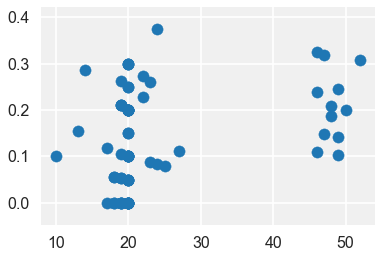

In [5]:
plt.scatter(tumordata.N, tumordata.y / tumordata.N)

In the 71st experiment, we are told that 4 out of 14 rats develop tumors. Our problem is to estimate the risk of tumor in the rats in the 71st experiment.

Thus we are considering the problem of estimating the tumor rate from a small experiment (no 71) and a prior constructed from previous experiments with similar structure. Mathematically, we consider the current and historical experiments as random samples from a common population.

In [6]:
tumor_rat = [e[0]/e[1] for e in zip(tumory, tumorn)]
tmean = np.mean(tumor_rat)
tvar = np.var(tumor_rat)
tmean, tvar

(0.13600653889043893, 0.010557640623609196)

(array([14.,  8., 14.,  3.,  3., 13.,  6.,  2.,  6.,  1.]),
 array([0.    , 0.0375, 0.075 , 0.1125, 0.15  , 0.1875, 0.225 , 0.2625,
        0.3   , 0.3375, 0.375 ]),
 <a list of 10 Patch objects>)

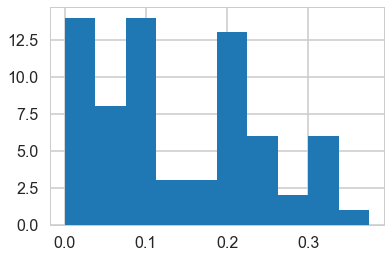

In [7]:
plt.hist(tumor_rat)

# Modeling

Since a rat is either have or don't have the tumor, it makes sense to use a Binomial model for **each** experiment, assumming a sample size $n_j$ and a probability $\theta_j$ that a rat has a tumor. For any one of the experiments, we have the likelihood: $$p(y_i|\theta_i, n_i) = Binom(n_i, y_i, \theta_i)$$

Then for all the experiment we have the likelihood: $$p(Y|\Theta, \{n_i\}) = \prod_{i=1}^{70}Binom(n_i, y_i, \theta_i)$$

### Picking prior $p(\Theta)$

### No pooling

Our first thought is to use Beta (conjugate prior to Binomial) for each $\theta_i$:

$$\begin{align}\theta_i &\sim Beta(\alpha_i, \beta_i)\\
p(\Theta|\{\alpha_i\},\{\beta_i\}) &= \prod_{i=1}^{70}Beta(\theta_i, \alpha_i, \beta_i)
\end{align}$$

where $\alpha_i$ and $\beta_i$ are **hyperparameters**.

These will leads to a very overfit models with 210 parameters and not much data. This model will have a large amount of variance, i.e, it is sensitive to outliers.

### Full pooling
The other extreme is to assume that there is only one $\theta$ in the problem, and set an prior on it, making this a three parameter problem. This ignores any variation amongst the sampling units other than sampling variance. Thus such a model might thus be underfit, unable to capture the variations in the samples. This is likely a model with a large amount of bias.

### Partial pooling 

We compromise and assume that each $\theta_i$ are drawn from a population distribution given by a conjugate Beta prior $Beta(\alpha, \beta)$ with parameters $\alpha$ and $\beta$ to describe this data.

$$\begin{align}\theta_i &\sim Beta(\alpha, \beta)\\
p(\Theta| \alpha, \beta) &= \prod_{i=1}^{70}Beta(\theta_i, \alpha, \beta)
\end{align}$$

The structure of this model is shown as follows: ![](./gfx/rat_model.png)

Models such as the one above are called **hierarchical model**, with observable outcomes ($Y_i$) modeled conditionally on certain parameters ($\theta_i)$, which themselves are given a probabilistic specification in terms of hyperparameters.

Modeling in this way has two advantages:

1. It helps us develop a computational strategy to solve the problem

2. It allows estimates of the probabilities of any one of the units (here, one of the experiments) to borrow strength from all the data as a whole through the estimation of the hyperparameters. In other words, if some of the experiments had lower sample sizes or other outlier like behavior, the procedure helps “regularize” this.

# Full Bayesian Treatment 1

# Full Bayesian Treatment 2

In this section, we repeat the same experiment but using different Metropolis-Hasting sampling methods.

In our rat tumor example, we have the hyperparameters are $(\alpha, \beta)$, which controls the distrubtion of parameters $\theta_j$, and $(y_j, n_j)$ as observed data. Then in a full Bayesian treatment, we need to derive analytically the following distributions:

1. joint posterior density of (hyper)parameters: $p(\theta, \phi|y) \propto p(\phi)p(\theta|\phi)p(y|\theta)$
2. conditional posterior densityo of parameters $\theta$: $p(\theta|\phi, y)$
3. estimate hyperparameters $\phi$ by derive its marginal posterior distribution $p(\phi \mid y) = \frac{p(\theta, \phi \mid y)}{p(\theta \mid \phi, y)}$ (conditional probability formula).

Applying these steps to the rat tumors we have.

**Step 1**: $$\begin{align}p(\Theta, \alpha, \beta \mid Y, \{n_i\})&\propto p(\alpha, \beta)p(\Theta|\alpha, \beta)p(y|\Theta, \alpha,\beta)\\&\propto p(\alpha, \beta) \prod_{i=1}^{70}Beta(\theta_i, \alpha, \beta)\prod_{i=1}^{70}Binom(n_i, y_i, \theta_i)\end{align}$$

Note that this is a high dimensional problem: there are 72 parameters (70 $\theta$s and $\alpha , \beta$).

**Step 2**:  The **conditional** posterior distribution for each of the $\theta_i$, given everything else is a Beta distribution itself (remember Beta is conjugate prior to Bionomial).

$p(\theta_i  \vert  y_i, n_i, \alpha, \beta) = Beta(\theta_i, \alpha + y_i, \beta + n_i - y_i)$ 

**Step 3**: For each of $\alpha$ and $\beta$, given everything else, the posterior distributions can be shown to be:

$$p(\alpha  \vert  Y, \Theta ,\beta ) \propto p(\alpha, \beta) \, \left(\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)}\right)^N \prod_{i=1}^{N} \theta_i^{\alpha}$$

$$P(\beta  \vert  Y, \Theta ,\alpha ) \propto p(\alpha, \beta) \, \left(\frac{\Gamma(\alpha + \beta)}{\Gamma(\beta)}\right)^N \prod_{i=1}^{N} (1 - \theta_i)^{\beta}$$

Note: The conditional posteriors do depend on $Y$ and $\{n\}$ via the $\theta$'s. 

### Hyperprior construction

In order to perform full bayesian treatment, we need to specify a hyper-priors, $p(\alpha, \beta)$, on these hyperparameters $(\alpha, \beta)$. Since we do not have any knowledge on the rate of tumors in rat experiments, we may wish to assign an improper prior distribution for the hyperparameters, $(\alpha, \beta)$, we must check that the posterior distribution $p(\alpha, \beta \mid y)$ is proper.

See the BDA book (p. 110) for the construction of the hyperpriors.

We select the prior $p(\alpha, \beta) \propto (\alpha + \beta)^{-5/2}$

# Sampling

In [8]:
# number of thetas
numthetas=tumorn.shape[0]
numthetas

70

We peform sampling from conditional posterior distribution of $\alpha$, $\beta$ and $\theta$ using Metropolis-Hastings style sampler.

In [9]:
from scipy.special import gammaln

# prior for the hyperparameters
def log_prior(a, b):
    if a <= 0 or b <=0:
        return -np.inf
    return -2.5*np.log(a + b)

# sampling from conditional posterior for the theta
draw_thetas = lambda a,b: beta.rvs(a+tumory,b+tumorn-tumory, size=numthetas)

# conditional posterior (pdf) for alpha
def log_cond_alpha(a,b, thetas):
    if a <= 0 or b <=0:
        return -np.inf
    return numthetas*(gammaln(a+b) - gammaln(a)) + a*np.sum(np.log(thetas)) + log_prior(a,b)
   
# conditional posterior (pdf) for beta
def log_cond_beta(a,b, thetas):
    if a <= 0 or b <=0:
        return -np.inf
    return numthetas*(gammaln(a+b) - gammaln(b)) + b*np.sum(np.log(1.0 - thetas)) + log_prior(a,b)
  
# using the above pdfs we draw for alpha and beta in MH fashion
def draw_alpha(a,b,thetas,proposal_sd, accepts):
    astar = norm.rvs(a,proposal_sd)  # proposed a new alpha
    num = log_cond_alpha(astar,b, thetas) 
    den = log_cond_alpha(a,b, thetas)
    R=np.random.rand()
    if (np.log(R) <= num - den): 
        accepted=1
    else:
        accepted=0
    accepts['alpha'] = accepts['alpha'] + accepted
    if accepted:
        return astar
    else:
        return a

def draw_beta(a,b,thetas,proposal_sd, accepts):
    bstar = norm.rvs(b,proposal_sd)
    num = log_cond_beta(a,bstar, thetas)
    den = log_cond_beta(a,b, thetas)
    R=np.random.rand()
    if (np.log(R) <= num - den):
        accepted=1
    else:
        accepted=0
    accepts['beta'] = accepts['beta'] + accepted
    if accepted:
        return bstar
    else:
        return b

In [12]:
burnin=20000
numtraces=200000
totaltraces=burnin+numtraces

alphas=np.empty(totaltraces)
betas=np.empty(totaltraces)
thetas=np.empty((totaltraces, numthetas))

# these are the step sizes for the proposal distribution
# for our M-H sampling for alpha and beta to be used in Gibbs sampling later
alpha_prop_sd=0.6
beta_prop_sd=3.2

#start positions
alphas[0]=1.
betas[0]=1.
thetas[0,:] = (tumory+0.5)/(tumorn+0.5)

#draw_thetas(alphas[0], betas[0])
accepteds={'alpha':0, 'beta':0}

In [13]:
start = time.clock()

In [14]:
for m in np.arange(1,totaltraces):
    alphas[m] = draw_alpha(alphas[m-1],betas[m-1],thetas[m-1,:], alpha_prop_sd, accepteds)
    betas[m] = draw_beta(alphas[m],betas[m-1],thetas[m-1,:], beta_prop_sd, accepteds)
    thetas[m,:] = draw_thetas(alphas[m],betas[m])

In [15]:
accepteds['alpha']/numtraces, accepteds['beta']/numtraces

(0.360055, 0.430505)

In [29]:
#remove burnin samples and thin
thin=40
alphatrace=alphas[burnin+1:totaltraces:thin]
betatrace=betas[burnin+1:totaltraces:thin]
thetatrace=thetas[burnin+1:totaltraces:thin,:]
print(thetastrace.shape, alphatrace.shape)

(5000, 70) (5000,)


Text(0,0.5,'beta')

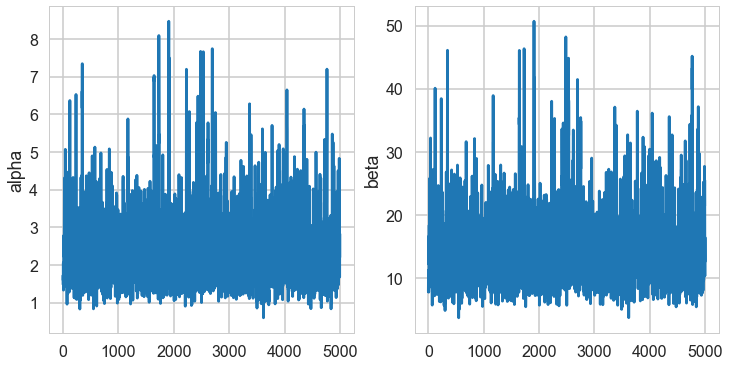

In [20]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.plot(alphatrace)
plt.ylabel('alpha')
plt.subplot(1,2,2)
plt.plot(betatrace)
plt.ylabel('beta')

In [38]:
def corrplot(trace, maxlags=50):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])

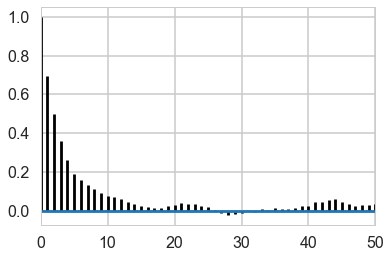

In [39]:
corrplot(alphatrace)


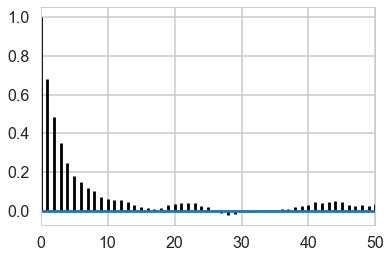

In [40]:
corrplot(betatrace)


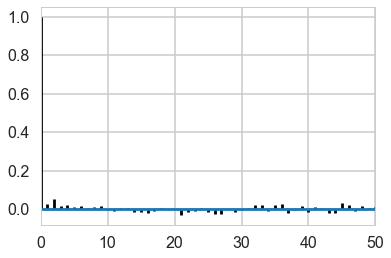

In [41]:
corrplot(thetastrace[:,7])


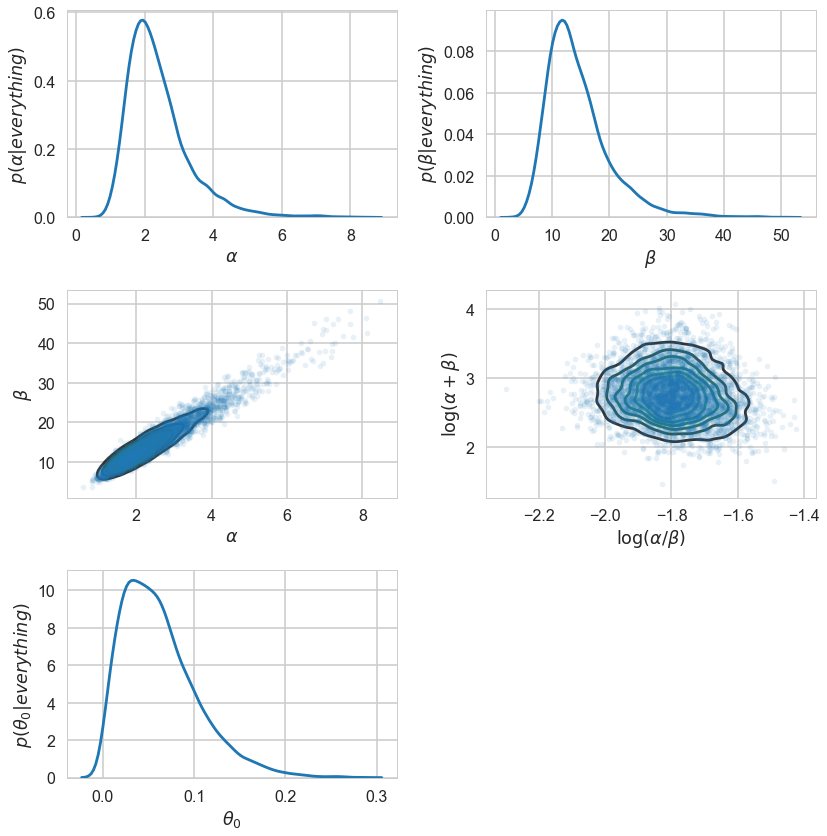

In [37]:
plt.figure(figsize=[12,12])
plt.subplot(3,2,1)
sns.kdeplot(alphatrace)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$p(\alpha \vert  everything)$')
plt.subplot(3,2,2)
sns.kdeplot(betatrace)
plt.xlabel(r'$\beta$')
plt.ylabel(r'$p(\beta \vert  everything)$')
plt.subplot(3,2,3)
plt.plot(alphatrace, betatrace,'.', alpha=0.1)
sns.kdeplot(alphatrace, betatrace)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')

plt.subplot(3,2,4)
plt.plot(np.log(alphatrace/betatrace), np.log(alphatrace+betatrace),'.', alpha=0.1)
sns.kdeplot(np.log(alphatrace/betatrace), np.log(alphatrace+betatrace))
plt.xlabel(r'$\log(\alpha/\beta)$')
plt.ylabel(r'$\log(\alpha+\beta)$')

plt.subplot(3,2,5)
sns.kdeplot(thetatrace[:,0])
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$p(\theta_0 \vert  everything)$')
plt.tight_layout()


In [22]:
percentiles=np.percentile(thetastrace, [2.5,50.0, 97.5], axis=0)
lowerthetas, medianthetas, upperthetas=percentiles

elowertheta = medianthetas - lowerthetas
euppertheta = upperthetas - medianthetas

In [24]:
empirical_ratios=tumory/tumorn


(-0.1, 0.5)

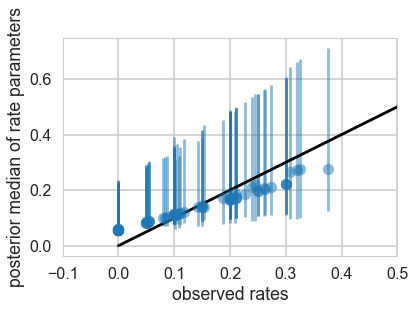

In [25]:
plt.errorbar(empirical_ratios, 
             medianthetas, yerr=[lowerthetas,upperthetas], fmt='o', alpha=0.5)
plt.plot([0,0.5],[0,0.5],'k-')
plt.xlabel("observed rates")
plt.ylabel("posterior median of rate parameters")
plt.xlim(-0.1,0.5)


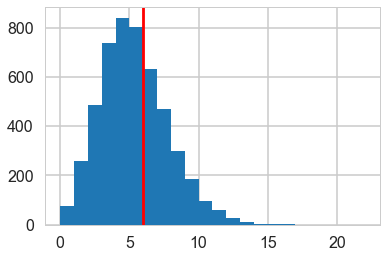

In [26]:
from scipy.stats import binom
pred60 = binom.rvs(tumorn[60],thetastrace[:,60])
plt.hist(pred60, bins=np.arange(tumorn[60]));
plt.axvline(tumory[60],0,1,color='r');

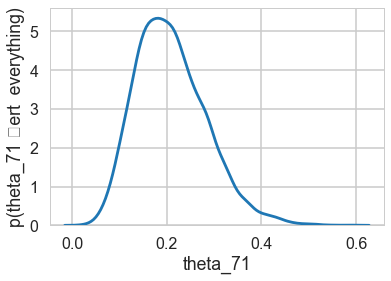

In [27]:
post71 = beta.rvs(alphatrace+4, betatrace+10)
sns.kdeplot(post71)
plt.xlabel('theta_71')
plt.ylabel('p(theta_71 \vert  everything)');

In [28]:
# numpy function falttens by default
percentiles =np.percentile(post71, [2.5,50.0, 97.5])

print("Percentiles: ", percentiles)
print("Naive rate: ", 4.0/14)

Percentiles:  [0.08865296 0.20118033 0.37370005]
Naive rate:  0.2857142857142857
